In [78]:
from typing import Callable, List, Any
from jax.experimental.host_callback import id_print
import flax.linen as nn
import jax
import jax.numpy as jnp
from jax import vmap, grad, jacrev, jacfwd, jit
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import random
import optax
from functools import partial
import flax
from tqdm.auto import tqdm
import jax

In [79]:
x64 = False

In [80]:
if x64:
    jax.config.update("jax_enable_x64", True)

def to_x64(a):
    return jnp.asarray(a, dtype=jnp.float64)

In [81]:
def jacsqzr(f, *args, **kwargs):
    return lambda *fargs, **fkwargs: jnp.squeeze(jacrev(f, *args, **kwargs)(*fargs, **fkwargs))


In [82]:
import h5py
from einops import rearrange

dirstr ='./ground_truth/burgersic_data/'
# fps = ['burgersic_30.mat_1D_1Q.hdf5','burgersic_32.mat_1D_1Q.hdf5','burgersic_34.mat_1D_1Q.hdf5','burgersic_36.mat_1D_1Q.hdf5','burgersic_38.mat_1D_1Q.hdf5','burgersic_40.mat_1D_1Q.hdf5']

# fps = ['./ground_truth/linadv_1p5_1D_1Q.hdf5', 'linadv_2p0_1D_1Q.hdf5']
mus = np.linspace(30,50,21,dtype=np.int32)
data = []
for mu in mus:
    mu = str(mu).replace('.','')
    filename = f'burgersic_{mu}.mat_1D_1Q.hdf5'
    filepath = f'{dirstr}/{filename}'
    with h5py.File(filepath, "r") as f:
        x = f['u'][:, ::4, ::4]
        data.append(x)

data_mu = jnp.asarray(data)

data = rearrange(data_mu, 'm q t x -> (m t) x q')
T, N, Q = data.shape


if x64:
    data = to_x64(data)
print(data.shape)

(21021, 512, 1)


In [83]:
# fp_test ='./ground_truth/burgers_vis-4e-3_1D_1Q.hdf5'

# for filepath in fps:
#     with h5py.File(fp_test, "r") as f:
#         data_test = f['u'][()]
# data_test = jnp.asarray(data_test)
# data_test = data_test[0, :, ::20]
# data_test = jnp.expand_dims(data_test, axis=-1)

In [84]:

def gen_noises(key, length, n_sigma, max_sigma):
    skey, nkey = jax.random.split(key)
    noise = jax.random.normal(nkey, shape=(n_sigma, length))
    sigma = jax.random.uniform(skey, shape=(n_sigma,), minval=0, maxval=max_sigma) 
    noise = noise * sigma[:, None]
    return noise

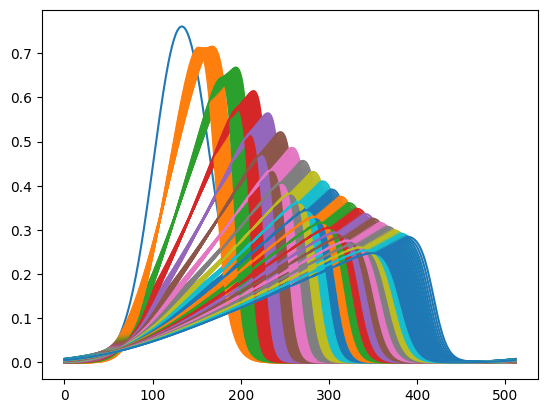

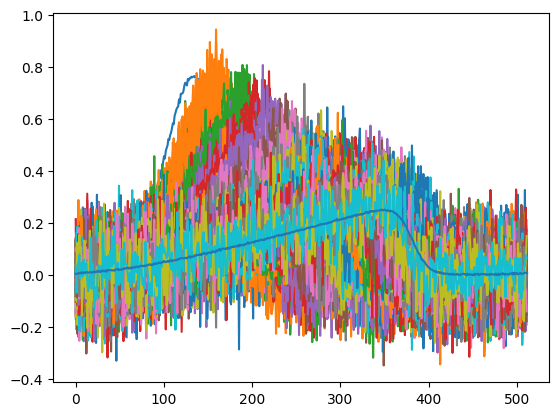

In [85]:
key = jax.random.PRNGKey(1)
max_sigma = 0.1
noise = gen_noises(key, data.shape[1], data.shape[0], max_sigma)
data_noise = data + noise[:,:,None]

plt.plot(jnp.squeeze(data[::50]).T)
plt.show()
plt.plot(jnp.squeeze(data_noise[::50]).T)
plt.show()

In [86]:
class Denoiser(nn.Module):
    features: int
    layers: int
    kernel_size: int = 3
    padding: str = 'CIRCULAR'
    bias:bool = False
    param_dtype:Any = jnp.float32


    @nn.compact
    def __call__(self, x):

        if x.shape[-1] != 1:
            x = jnp.expand_dims(x, axis=-1)
        A = nn.swish

        for l in range(self.layers-1):
            L = nn.Conv(features=self.features, kernel_size=(
                self.kernel_size,), padding=self.padding, use_bias=self.bias, param_dtype=self.param_dtype)
            # L = nn.WeightNorm(L, param_dtype=self.param_dtype)
            x = L(x)
            # x = nn.LayerNorm()(x)
            x = A(x)

        L = nn.Conv(features=1, kernel_size=(
            self.kernel_size,), padding=self.padding, use_bias=self.bias, param_dtype=self.param_dtype)
        # L = nn.WeightNorm(L, param_dtype=self.param_dtype)
        x = L(x)
        return x

In [87]:
dtype = jnp.float32
if x64:
    dtype = jnp.float64

DeNet = Denoiser(features=55, layers=7, kernel_size=20, bias=False, param_dtype=dtype)
key, skey = jax.random.split(key)
theta_init = DeNet.init(key, data)
theta_init_flat, unravel = jax.flatten_util.ravel_pytree(theta_init)
F = DeNet.apply

2023-11-28 15:08:46.830361: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[21021,55,512]{2,1,0}, u8[0]{0}) custom-call(f32[21021,55,531]{2,1,0}, f32[55,55,20]{2,1,0}), window={size=20}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2023-11-28 15:08:49.085897: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 3.255605913s
Trying algorithm eng0{} for conv (f32[21021,55,512]{2,1,0}, u8[0]{0}) custom-call(f32[21021,55,531]{2,1,0}, f32[55,55,20]{2,1,0}), window={size=20}, dim_labels=bf0_oi0->bf0, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2023-11-28 15:08:54.613030: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv

In [88]:
# from jax import jvp, vjp
# def estiamte_trace(key, f, X, length):
#     v = jax.random.rademacher(key, shape=(length,), dtype=jnp.float32)
#     Jv = jvp(f, (X,), (v,))[1]
#     trace = v.T@Jv
#     return trace
    
# v_estiamte_trace = vmap(estiamte_trace, (None, None, 0, None))


In [89]:
from tqdm.auto import tqdm
iters = 2000
pbar = tqdm(range(iters))
lr = 2e-3


def loss_fn(params, y, key):
    tkey, nkey = jax.random.split(key)

    # add noise
    noise = gen_noises(nkey, y.shape[1], y.shape[0], max_sigma)
    x = y + noise[:, :, None]

    # denoise
    y_hat = F(params, x)

    # MSE
    loss = (y - y_hat)**2
    loss = loss.mean()  

    return loss


def update_step(optimizer, params, y, opt_state, key):

    total_loss, grads = jax.value_and_grad(
        loss_fn
    )(params, y, key)

    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    return opt_state, params, total_loss


learning_rate = optax.cosine_decay_schedule(init_value=lr, decay_steps=iters)
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(theta_init)
update_step = partial(update_step, optimizer)
update_step = jit(update_step)
params = theta_init
batch_size = 1000
for i in pbar:
    nkey, skey, key = jax.random.split(key, 3)

    idx = jax.random.choice(skey, len(data), shape=(batch_size, ))
    y = data[idx]
    opt_state, params, total_loss = update_step(
        params, y, opt_state, nkey)
    pbar.set_postfix({'loss': f'{total_loss:.2E}'})

  0%|          | 0/2000 [00:00<?, ?it/s]

In [90]:
def normalize(a):
    return a/np.linalg.norm(a)

In [91]:
@jit
def get_eig_vec(A, k=None):
    e_val, e_vec = jnp.linalg.eigh(A)
    idx = e_val.argsort()[::-1]   
    e_val = e_val[idx]
    e_vec = e_vec[:,idx]
    return e_val, e_vec

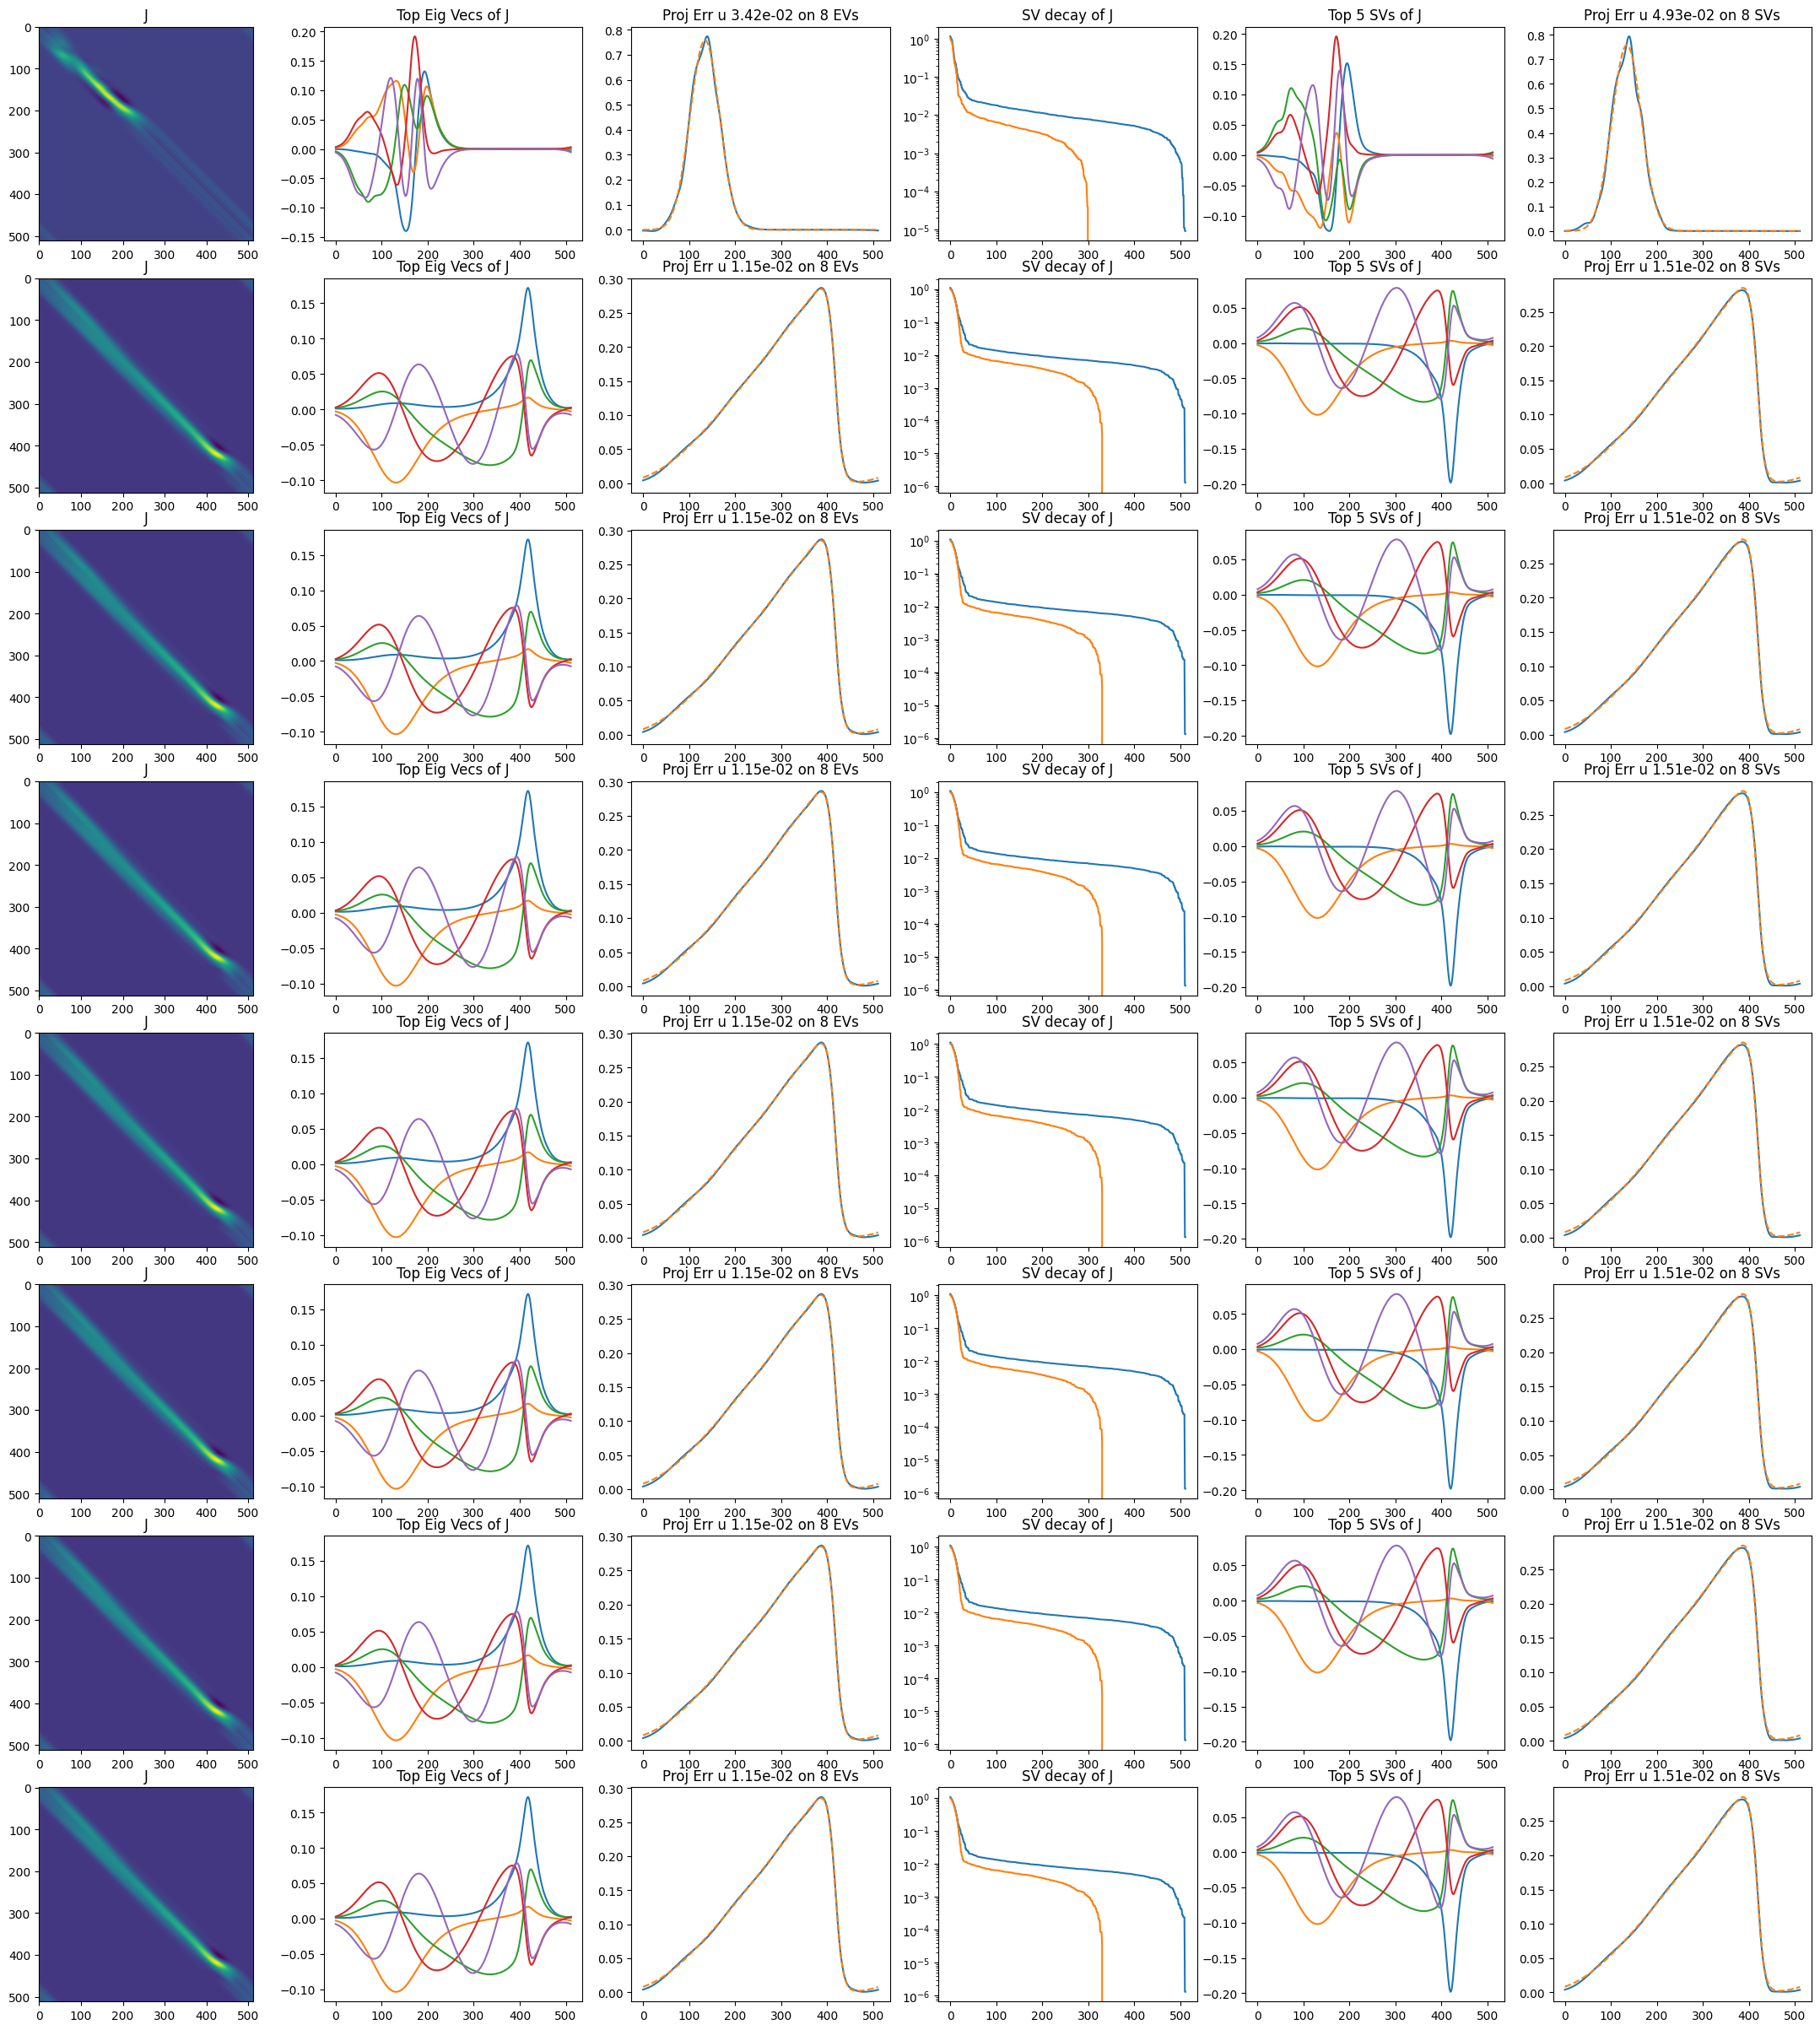

In [92]:
n_examples = 8 # number of examples to plot

examples_i = np.linspace(2, len(data)-1,n_examples, dtype=np.int32)
fig, axes = plt.subplots(n_examples, 6, figsize=(22,n_examples*3))
fig.tight_layout()
J_fn = jacsqzr(F, 1)

data_plot = data_mu[0][0]
for ax_i,i in enumerate(examples_i):
    n_svs = 5
    p_svs = 8
    ax = axes[ax_i]
    u = np.squeeze(data_plot[i])

    # plot jacobian
    J = J_fn(params, u)
    ax[0].imshow(J)
    ax[0].set_title(f'J')

    e_val, e_vec = get_eig_vec(J)
    ax[1].plot(e_vec[:, :n_svs])
    ax[1].set_title(f'Top Eig Vecs of J')
    
   
    # compute projection on u error 
    p_svs = 8
    B = e_vec[:, :p_svs]
    sol, res, rank, s_vals = jnp.linalg.lstsq(B, u)
    apx_u = B@sol
    ax[2].plot(apx_u)
    ax[2].plot(u, '--')
    err = np.linalg.norm(u - apx_u) / np.linalg.norm(u)
    ax[2].set_title(f'Proj Err u {err:.2e} on {p_svs} EVs')

    U, s, Vt = jnp.linalg.svd(J)
    # plto sv decay
    J = J_fn(params, u)
    ax[3].semilogy(s)
    ax[3].semilogy(e_val/ e_val[0])
    ax[3].set_title(f'SV decay of J')

    # plot top svs

    SVs = U[:, :n_svs]
    ax[4].plot(SVs)
    ax[4].set_title(f'Top {n_svs} SVs of J')
   
    # compute projection on u error 
    B = U[:, :p_svs]
    sol, res, rank, s_vals = jnp.linalg.lstsq(B, u)
    apx_u = B@sol
    ax[5].plot(apx_u)
    ax[5].plot(u, '--')
    err = np.linalg.norm(u - apx_u) / np.linalg.norm(u)
    ax[5].set_title(f'Proj Err u {err:.2e} on {p_svs} SVs')
   
plt.show()


In [93]:
n_examples = 6  # number of examples to plot
n_svs_samples = 15
max_svs = 25
err_per_sv = []
num_svs = np.linspace(1, max_svs, n_svs_samples, dtype=np.int32)

data_plot = data_mu[0][0]
for num_sv in num_svs:
    examples_i = np.linspace(1000, len(data)-1, n_examples, dtype=np.int32)
    rel_errs = 0.0
    for i in examples_i:
        u = np.squeeze(data_plot[i])
        J = J_fn(params, u)
        # U, s, Vt = jnp.linalg.svd(J)
        # B = U[:, :num_sv]

        e_val, E = get_eig_vec(J)
        B = E[:, :num_sv]

        sol, res, rank, s_vals = jnp.linalg.lstsq(B, u)
        apx_u = B@sol

        err = np.linalg.norm(u - apx_u) / np.linalg.norm(u)
        rel_errs += err

    rel_errs /= n_examples
    err_per_sv.append(rel_errs)

In [94]:
snapshots = jnp.squeeze(data) #jnp.concatenate([jnp.squeeze(data), jnp.squeeze(data)])
U, pod_s, Vt = jnp.linalg.svd(snapshots)
pod_s = pod_s/pod_s[0]

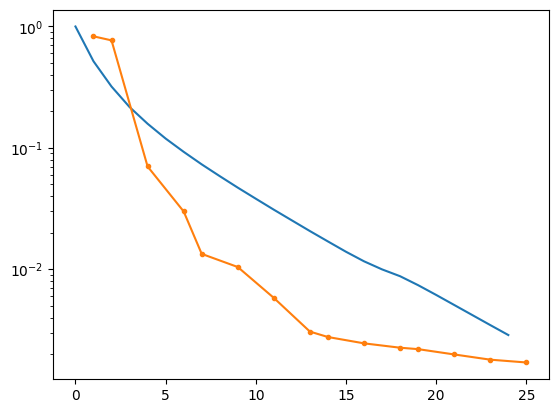

In [95]:
plt.semilogy(pod_s[:max_svs])
plt.semilogy(num_svs, err_per_sv, '.-')
plt.show()

In [96]:
num_sv = 10
@jit
def compute_coffs(ss, lastB):
    J = J_fn(params, ss)
    # U, s, _ = jnp.linalg.svd(J)
    # B = U[:, :10]

    e_val, E = get_eig_vec(J)
    B = E[:, :num_sv]

    # plt.imshow(B)
    # plt.show()
    if lastB is not None:
        bsol = jnp.linalg.lstsq(lastB, B)[0]
        aidx = jnp.argmax(jnp.abs(bsol), axis=0, keepdims=True)
        vals = jnp.take_along_axis(bsol, aidx, axis=0)[0]
        bperm = jnp.zeros_like(bsol)
        bperm = jnp.where(bsol == vals, jnp.rint(vals), 0.0)
        B = B@bperm

    # B *= jnp.sign(jnp.mean(B,axis=0))
    coff = B.T@ ss

    
    # if lastC is not None:
    #     eps = 0.01
    #     coff = jnp.where(coff > eps, coff, jnp.copysign(coff, lastC))
    return coff, B

In [97]:
data_mu.shape

(21, 1, 1001, 512)

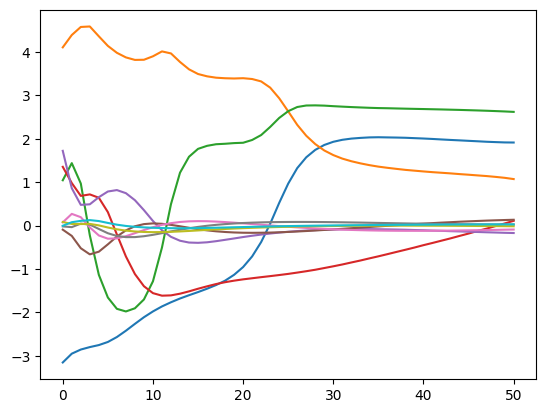

In [98]:
coffs = []
Bs = []
lastB = None
for ss in data_mu[0, 0, ::20]:
    coff, B = compute_coffs(ss, lastB)
    coffs.append(coff)
    lastB = B
    Bs.append(B)


coffs = np.asarray(coffs)

plt.plot(coffs)
plt.show()

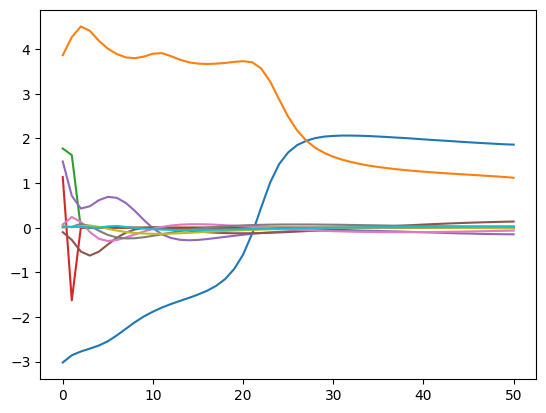

In [99]:
coffs = []
lastB = None
for ss in data_mu[4, 0, ::20]:
    coff, B = compute_coffs(ss, lastB)
    coffs.append(coff)
    lastB = B


coffs = np.asarray(coffs)

plt.plot(coffs)
plt.show()

In [100]:
from jax.experimental.host_callback import id_print, id_tap

@jit
def loss(x, alpha):
    J = J_fn(params, x)
    _, E = get_eig_vec(J)
    B = E[:, :num_sv]
    x_hat = B@alpha
    loss = (x - x_hat)**2
    loss = loss.mean()
    id_print(loss)
    return loss


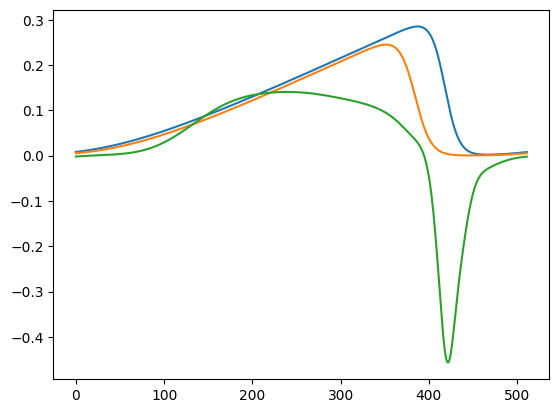

In [101]:
x_true  = data_mu[-1, 0, -1]
x_hat_guess =  data_mu[0, 0, -1]
alpha , _ = compute_coffs(x_true, None)
J = J_fn(params, x_hat_guess)
U, _, _ = jnp.linalg.svd(J, full_matrices=False)
B = U[:, :10]
plt.plot(x_hat_guess)
plt.plot(x_true)
plt.plot(B@alpha)
plt.show()

In [102]:
import jaxopt


# solver = jaxopt.LBFGS(fun=loss,  maxiter=100, tol=1e-5)
# x_hat, state = solver.run(x_hat_guess, alpha)


# solver = jaxopt.ScipyMinimize(fun=loss, method='L-BFGS-B',  maxiter=100, tol=1e-5)
# x_hat, state = solver.run(x_hat_guess, alpha)

adam_opt(x_hat_guess, loss, (alpha,), init_state=None, steps=500, learning_rate=1e-3)

NameError: name 'adam_opt' is not defined

NameError: name 'x_hat' is not defined

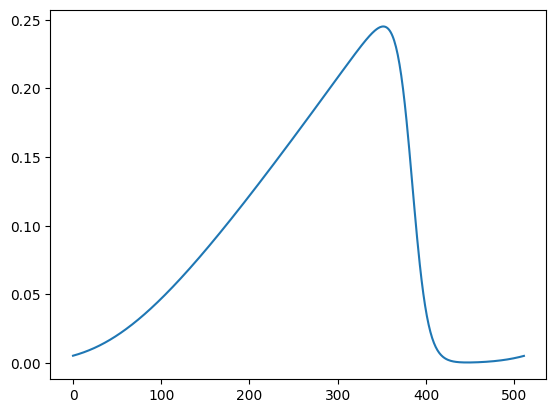

In [ ]:
plt.plot(x_true)
plt.plot(x_hat)
plt.plot(x_hat_guess, '--')
plt.show()

In [ ]:
def adam_opt(theta_init, loss_fn, args_fn, init_state=None, steps=500, learning_rate=1e-3, scheduler=True, verbose=False, loss_tol=None, optimizer='adam', key=None):
    # adds warm up cosine decay
    if scheduler:
        learning_rate = optax.cosine_decay_schedule(
            init_value=learning_rate,
            decay_steps=steps,
            alpha=0.0
        )

    optimizer =  optax.adam(learning_rate=learning_rate)

    state = optimizer.init(theta_init)
    if init_state is not None:
        state = init_state

    @jit
    def step(params, state, args):
        loss_value, grads = jax.value_and_grad(
            loss_fn)(params, *args)
        updates, state = optimizer.update(grads, state, params)
        params = optax.apply_updates(params, updates)
        return loss_value, params, state

    params, opt_params = theta_init, theta_init
    pbar = tqdm(range(steps), disable=not verbose)
    if key is None:
        key = jax.random.PRNGKey(random.randint(0, 1000))
    itr = 0
    opt_loss = float('inf')
    loss_history = []
    n_rec = max(steps // 1000, 1)

    for i in pbar:
        key, stepkey, argkey = jax.random.split(key, 3)

        if callable(args_fn):
            args = args_fn(i, argkey)
        else:
            args = args_fn
        cur_loss, params_new, state_new = step(
            params, state, args)

        pbar.set_postfix({'loss': f'{cur_loss:.3E}'})

        if cur_loss < opt_loss:
            opt_loss = cur_loss
            opt_params = params_new

        if i % n_rec:
            loss_history.append(cur_loss)

        params = params_new
        state = state_new
        itr += 1
        if loss_tol is not None and cur_loss < loss_tol:
            break

    loss_history = np.asarray(loss_history)
    return opt_params, loss_history


In [ ]:
# n_examples = 5 # number of examples to plot

# examples_i = np.linspace(2, len(data)-1,n_examples, dtype=np.int32)
# fig, axes = plt.subplots(n_examples, 6, figsize=(22,n_examples*3))
# fig.tight_layout()
# J_fn = jacsqzr(F, 1)

# for ax_i,i in enumerate(examples_i):
#     ax = axes[ax_i]
#     u = np.squeeze(data[i])

#     # plot jacobian
#     J = J_fn(params, u)
#     ax[0].imshow(J)
#     ax[0].set_title(f'J')

#     U, s, Vt = jnp.linalg.svd(J)
#     # plto sv decay
#     J = J_fn(params, u)
#     ax[1].semilogy(s)
#     ax[1].set_title(f'SV decay of J')

#     # plot top svs
#     n_svs = 2
#     SVs = U[:, :n_svs]
#     SVs *= np.sign(np.mean(SVs, axis=0)) # orient the SV to point up
#     ax[2].plot(SVs)
#     ax[2].set_title(f'Top {n_svs} SVs of J')
#     # get approx normalized time derivative
#     u_t = normalize(data[i] - data[i-1])
#     ax[3].plot(u_t, label='u_t')
#     ax[3].plot(normalize(u), '--', label='u')
#     ax[3].legend()
#     ax[3].set_title(f'u_t')
  
#     # compute projection error 
#     p_svs = 6 # size of subpsace to project on
#     B = U[:, :p_svs]
#     sol, res, rank, s_vals = jnp.linalg.lstsq(B, u_t)
#     apx_u = B@sol
#     ax[4].plot(apx_u)
#     ax[4].plot(u_t, '--')
#     err = np.linalg.norm(u_t - apx_u) / np.linalg.norm(u_t)
#     ax[4].set_title(f'Proj Err u_t {err:.2e} on {p_svs} SVs')
   
#     # compute projection on u error 

#     B = U[:, :p_svs]
#     sol, res, rank, s_vals = jnp.linalg.lstsq(B, u)
#     apx_u = B@sol
#     ax[5].plot(apx_u)
#     ax[5].plot(u, '--')
#     err = np.linalg.norm(u - apx_u) / np.linalg.norm(u)
#     ax[5].set_title(f'Proj Err u {err:.2e} on {p_svs} SVs')
   
# plt.show()
